#### 3 channels

In [2]:
# Update the notebook to incorporate any changes made in the environment
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# imports

# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Unet
from monai.networks.nets import UNet

In [60]:
from src.load_XY import load_XY_3chanel

# Dataset import:
data_folder = "./data"

X, y = load_XY_3chanel(data_folder)

##### Preprocessing

In [61]:
import random
import numpy as np

# Combine X and y into a list of tuples
data = list(zip(X, y))

# Assuming each patient has 80 lists of tensors
lists_per_patient = 80

# Total number of patients
total_patients = len(data) // lists_per_patient

# Set the seed for reproducibility
random.seed(42)

# Shuffle the indices of patients
shuffled_patients = list(range(total_patients))
random.shuffle(shuffled_patients)

# Calculate the number of patients for each split
train_patients = 58
val_patients = 16
test_patients = 8

# Extract data for each split based on the shuffled indices
train_indices = shuffled_patients[:train_patients]
val_indices = shuffled_patients[train_patients: train_patients + val_patients]
test_indices = shuffled_patients[train_patients + val_patients: train_patients + val_patients + test_patients]

# Extract data for each split
train_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in train_indices]
val_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in val_indices]
test_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in test_indices]

# Flatten the lists of lists into a single list for X and y
X_train, y_train = zip(*[item for sublist in train_data for item in sublist])
X_val, y_val = zip(*[item for sublist in val_data for item in sublist])
X_test, y_test = zip(*[item for sublist in test_data for item in sublist])

# Convert train, test and val into numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [62]:
# lenghts of train, test and val
print(f"Dimension of training set: {len(X_train), len(y_train)}\n")
print(f"Dimension of test set: {len(X_test), len(y_test)}\n")
print(f"Dimension of validation set: {len(X_val), len(y_val)}")

Dimension of training set: (4640, 4640)

Dimension of test set: (640, 640)

Dimension of validation set: (1280, 1280)


In [63]:
import torch

# Convert numpy array to tensors
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_val = torch.from_numpy(X_val).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)


# Match y dimension to the X
# y_train is a NumPy array
y_train = y_train[:, np.newaxis, :, :]
# Now, y_train has shape (4640, 1, 64, 64)

y_val = y_val[:, np.newaxis, :, :]
y_test = y_test[:, np.newaxis, :, :]

In [64]:
y_train.shape

(4640, 1, 64, 64)

In [70]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Creation of dataloaders
train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=16, shuffle=True)
validation_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=16, shuffle=False)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size=16, shuffle=False)

##### Model building

In [26]:
from src.unet_from_scratch import UNet

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = UNet(n_class=1, in_channels=3).to(device)

# print the model architecture
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [14]:
from torch import nn

model_save_path = "./model/MSE_3c_100ep_lr4.pth"
loss_fn = nn.MSELoss()
epochs = 100
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.0079
Validation loss: 0.0012

Epoch 2/100, loss: 0.0012
Validation loss: 0.0009

Epoch 3/100, loss: 0.0008
Validation loss: 0.0006

Epoch 4/100, loss: 0.0006
Validation loss: 0.0005

Epoch 5/100, loss: 0.0005
Validation loss: 0.0004

Epoch 6/100, loss: 0.0004
Validation loss: 0.0003

Epoch 7/100, loss: 0.0003
Validation loss: 0.0002

Epoch 8/100, loss: 0.0002
Validation loss: 0.0002

Epoch 9/100, loss: 0.0002
Validation loss: 0.0002

Epoch 10/100, loss: 0.0002
Validation loss: 0.0002

Epoch 11/100, loss: 0.0002
Validation loss: 0.0002

Epoch 12/100, loss: 0.0002
Validation loss: 0.0003

Epoch 13/100, loss: 0.0003
Validation loss: 0.0002

Epoch 14/100, loss: 0.0002
Validation loss: 0.0002

Epoch 15/100, loss: 0.0002
Validation loss: 0.0002

Epoch 16/100, loss: 0.0002
Validation loss: 0.0002

Epoch 17/100, loss: 0.0002
Validation loss: 0.0002

Epoch 18/100, loss: 0.0002
Validation loss: 0.0002

Epoch 19/100, loss: 0.0002
Validation loss: 0.0002

Epoch 20/100, loss: 0

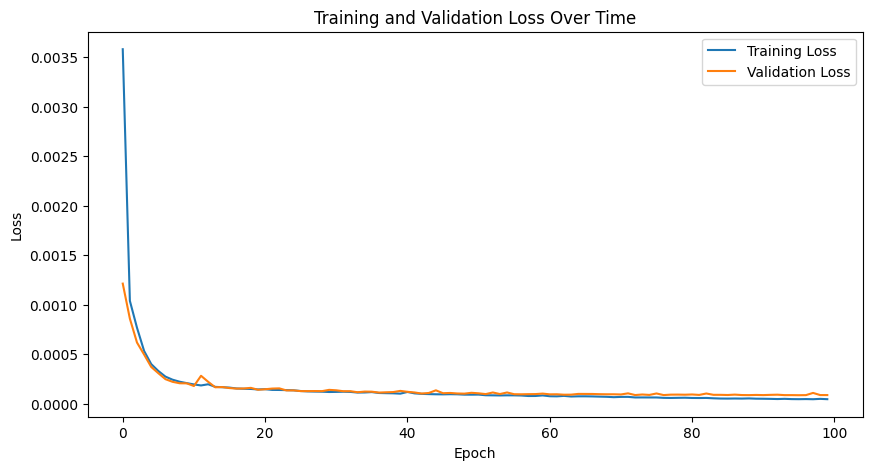




Test set: 
 Avg PSNR: 41.6 dB, Avg loss: 0.000070
  Min PSNR: 40.5 dB, Max PSNR: 42.2 dB



In [15]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [18]:
from torch import nn

model_save_path = "./model/BisMSE_3c_100ep_lr4.pth"
loss_fn = nn.MSELoss()
epochs = 100
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.0079
Validation loss: 0.0012

Epoch 2/100, loss: 0.0012
Validation loss: 0.0008

Epoch 3/100, loss: 0.0008
Validation loss: 0.0006

Epoch 4/100, loss: 0.0006
Validation loss: 0.0005

Epoch 5/100, loss: 0.0005
Validation loss: 0.0004

Epoch 6/100, loss: 0.0004
Validation loss: 0.0003

Epoch 7/100, loss: 0.0003
Validation loss: 0.0003

Epoch 8/100, loss: 0.0003
Validation loss: 0.0002

Epoch 9/100, loss: 0.0003
Validation loss: 0.0002

Epoch 10/100, loss: 0.0003
Validation loss: 0.0002

Epoch 11/100, loss: 0.0002
Validation loss: 0.0002

Epoch 12/100, loss: 0.0002
Validation loss: 0.0002

Epoch 13/100, loss: 0.0002
Validation loss: 0.0002

Epoch 14/100, loss: 0.0002
Validation loss: 0.0002

Epoch 15/100, loss: 0.0002
Validation loss: 0.0002

Epoch 16/100, loss: 0.0002
Validation loss: 0.0002

Epoch 17/100, loss: 0.0002
Validation loss: 0.0002

Epoch 18/100, loss: 0.0002
Validation loss: 0.0001

Epoch 19/100, loss: 0.0002
Validation loss: 0.0001

Epoch 20/100, loss: 0

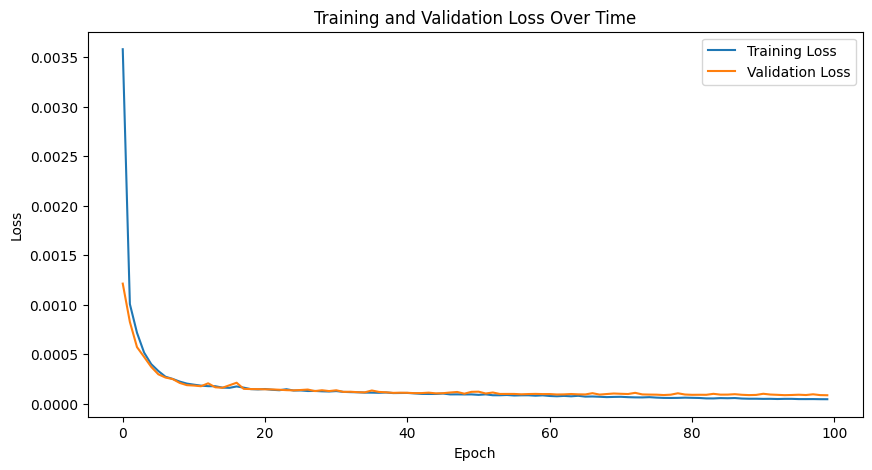




Test set: 
 Avg PSNR: 41.3 dB, Avg loss: 0.000078
  Min PSNR: 38.6 dB, Max PSNR: 43.2 dB



In [19]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [20]:
print("fin")

fin


In [24]:
from src.unet_from_scratch import UNet

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = UNet(n_class=1, in_channels=3).to(device)

# print the model architecture
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [22]:
from torch import nn

model_save_path = "./model/MSE_3c_300ep_lr4.pth"
loss_fn = nn.MSELoss()
epochs = 100
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.0072
Validation loss: 0.0013

Epoch 2/100, loss: 0.0013
Validation loss: 0.0010

Epoch 3/100, loss: 0.0010
Validation loss: 0.0007

Epoch 4/100, loss: 0.0007
Validation loss: 0.0005

Epoch 5/100, loss: 0.0005
Validation loss: 0.0004

Epoch 6/100, loss: 0.0004
Validation loss: 0.0003

Epoch 7/100, loss: 0.0003
Validation loss: 0.0003

Epoch 8/100, loss: 0.0003
Validation loss: 0.0002

Epoch 9/100, loss: 0.0003
Validation loss: 0.0002

Epoch 10/100, loss: 0.0003
Validation loss: 0.0002

Epoch 11/100, loss: 0.0002
Validation loss: 0.0002

Epoch 12/100, loss: 0.0002
Validation loss: 0.0002

Epoch 13/100, loss: 0.0002
Validation loss: 0.0002

Epoch 14/100, loss: 0.0002
Validation loss: 0.0002

Epoch 15/100, loss: 0.0002
Validation loss: 0.0002

Epoch 16/100, loss: 0.0002
Validation loss: 0.0002

Epoch 17/100, loss: 0.0002
Validation loss: 0.0002

Epoch 18/100, loss: 0.0001
Validation loss: 0.0002

Epoch 19/100, loss: 0.0002
Validation loss: 0.0002

Epoch 20/100, loss: 0

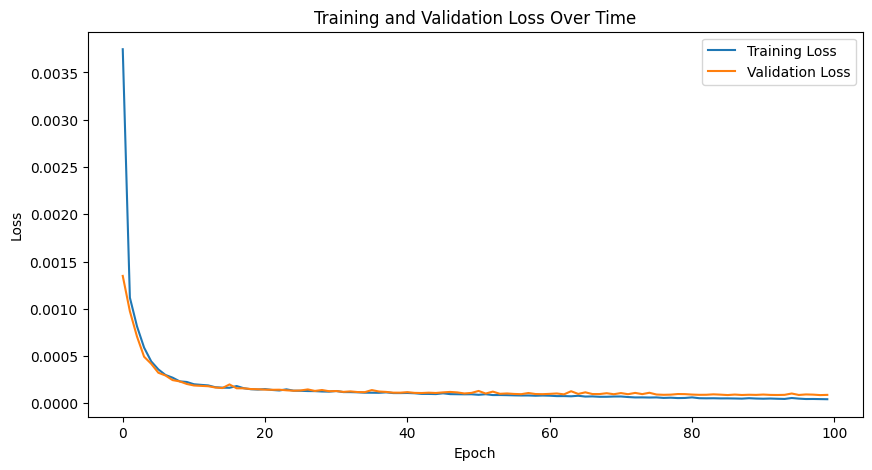




Test set: 
 Avg PSNR: 41.5 dB, Avg loss: 0.000073
  Min PSNR: 39.2 dB, Max PSNR: 43.0 dB



In [23]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [27]:
from torch import nn

model_save_path = "./model/MSE_3c_300ep_lr4.pth"
loss_fn = nn.MSELoss()
epochs = 300
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/300, loss: 0.0169
Validation loss: 0.0018

Epoch 2/300, loss: 0.0018
Validation loss: 0.0010

Epoch 3/300, loss: 0.0010
Validation loss: 0.0007

Epoch 4/300, loss: 0.0007
Validation loss: 0.0005

Epoch 5/300, loss: 0.0005
Validation loss: 0.0004

Epoch 6/300, loss: 0.0004
Validation loss: 0.0003

Epoch 7/300, loss: 0.0003
Validation loss: 0.0003

Epoch 8/300, loss: 0.0003
Validation loss: 0.0002

Epoch 9/300, loss: 0.0002
Validation loss: 0.0002

Epoch 10/300, loss: 0.0002
Validation loss: 0.0002

Epoch 11/300, loss: 0.0002
Validation loss: 0.0002

Epoch 12/300, loss: 0.0002
Validation loss: 0.0002

Epoch 13/300, loss: 0.0002
Validation loss: 0.0002

Epoch 14/300, loss: 0.0002
Validation loss: 0.0002

Epoch 15/300, loss: 0.0002
Validation loss: 0.0002

Epoch 16/300, loss: 0.0002
Validation loss: 0.0002

Epoch 17/300, loss: 0.0002
Validation loss: 0.0002

Epoch 18/300, loss: 0.0002
Validation loss: 0.0002

Epoch 19/300, loss: 0.0002
Validation loss: 0.0002

Epoch 20/300, loss: 0

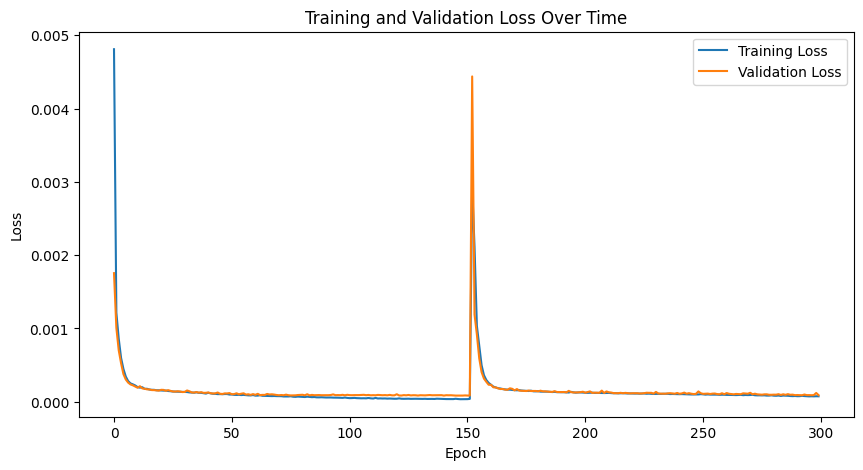




Test set: 
 Avg PSNR: 41.1 dB, Avg loss: 0.000078
  Min PSNR: 40.3 dB, Max PSNR: 42.2 dB



In [28]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

##### Prediction

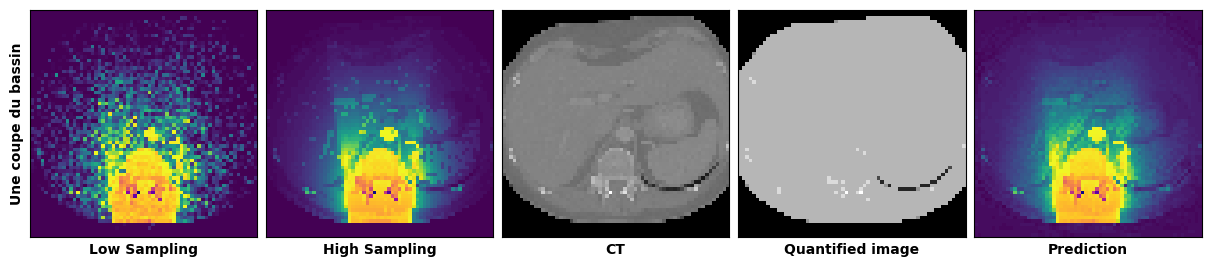

In [3]:
from src.predict import predict3
from src.visualization import visualize_prediction
import torch

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# load the images for visualization
low = "./test/low_edep.mhd"
ct = "./test/ct.mhd"
ground_truth_data = "./test/high_edep.mhd"
annotated = "./test/annotated_ct.npy"

# define paths for loading the features and saving the output visualization
paths = "./test/"
save_path = "./images/unet_MSE_3c_100ep_lr4.png"


# define path for model trained
model_path = './model/MSE_3c_100ep_lr4.pth'


# load the model
model = torch.load(model_path)

# make prediction
predicted_data = predict3(model, paths, device=device)

# Visualisation
visualize_prediction(low, ground_truth_data, predicted_data, save_path, ct, annotated)